## Create custom dataset
<https://pytorch.org/tutorials/beginner/basics/data_tutorial.html>

In [1]:
import torchvision.io
from sklearn.preprocessing import LabelEncoder
import librosa
from birdclassification.preprocessing.filtering import filter_recordings_30
from torch.utils.data import Dataset
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

class CustomAudioDataset(Dataset):
    def __init__(self, df, recording_dir, transform=None, target_transform=None):
        """
        Parameters
        ----------
        df: pd.DataFrame
            DataFrame of xeno-canto recordings
        recording_dir: str
            filepath to directory with recordings
        transform:
        target_transform:
        """
        
        df['filepath'] = df.apply(lambda x: f"{recording_dir}{x['Latin name']}/{str(x['id'])}.mp3" , axis=1)
        le = LabelEncoder()
        df['label'] = le.fit_transform(df['Latin name'])
        
        self.filepath = df['filepath'].to_numpy()
        self.label = df['label'].to_numpy()
        self.recording_dir = recording_dir
        self.transform = transform
        self.target_transform = target_transform
        self.le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

    def __len__(self):
        return self.filepath.size

    def __getitem__(self, idx):
        audio, sr = librosa.load(self.filepath[idx])
        label = self.label[idx]
        
        audio = torch.from_numpy(audio).type(torch.float32)
        label = torch.tensor(label, dtype=torch.int8)
        
        if self.transform:
            audio = self.transform(audio)
        if self.target_transform:
            label = self.target_transform(label)
        
        return audio, label


## Split dataset

In [2]:
RECORDINGS_DIR = '/media/jacek/E753-A120/recordings_30/'

df = filter_recordings_30()

train_df, test_val_df = train_test_split(df, stratify=df['Latin name'], test_size=0.2)
val_df, test_df = train_test_split(test_val_df, stratify=test_val_df['Latin name'], test_size=0.5)

train_ds = CustomAudioDataset(train_df, recording_dir=RECORDINGS_DIR)
val_ds = CustomAudioDataset(val_df, recording_dir=RECORDINGS_DIR)
test_ds = CustomAudioDataset(test_df, recording_dir=RECORDINGS_DIR)

/home/jacek/PycharmProjects/Bird-classification-model/birdclassification/preprocessing/filtering.py:43: DtypeWarning: Columns (10,39,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  recordings = pd.read_csv("../data/xeno_canto_recordings.csv")


In [3]:
print(train_ds.__len__())
print(val_ds.__len__())
print(test_ds.__len__())

32968
4121
4121


In [4]:
for i in range(5):
    print(train_ds[i])


(tensor([-0.0002, -0.0004, -0.0006,  ...,  0.0066,  0.0035, -0.0009]), tensor(0, dtype=torch.int8))
(tensor([1.8626e-09, 9.3132e-10, 2.3283e-09,  ..., 1.1002e-02, 7.2554e-03,
        8.1812e-03]), tensor(11, dtype=torch.int8))
(tensor([ 2.4839e-11, -1.0325e-10,  8.6430e-11,  ...,  0.0000e+00,
         0.0000e+00,  0.0000e+00]), tensor(5, dtype=torch.int8))
(tensor([ 1.2409e-10,  3.0778e-11,  1.1883e-11,  ..., -2.1471e-05,
        -1.7100e-05,  0.0000e+00]), tensor(20, dtype=torch.int8))
(tensor([0.0365, 0.0404, 0.0404,  ..., 0.0366, 0.0383, 0.0000]), tensor(1, dtype=torch.int8))


## DataLoader

In [5]:
train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=64, shuffle=True)

In [6]:
for element in train_dataloader:
    print(element)

RuntimeError: stack expects each tensor to be equal size, but got [392405] at entry 0 and [11090017] at entry 1

## Example of custom  transform (on image)

In [7]:
class MyCustomTransform(torch.nn.Module):
    def forward(self, img):
        img = v2.RandomRotation(degrees=(0, 180))(img)
        return img

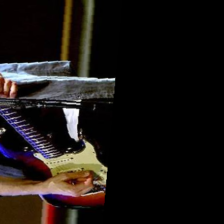

In [8]:
# Image Classification
import torch
from torchvision.io import read_image
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import torchvision.transforms as T


img = torchvision.io.read_image('josh.jpg')

transforms = v2.Compose([
    MyCustomTransform(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    # v2.RandomHorizontalFlip(p=0.5),
    # v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img = transforms(img)
T.ToPILImage()(img)


## Example of custom transform on audio

In [9]:
import torchaudio
from torchaudio.transforms import Resample, TimeStretch, Spectrogram, FrequencyMasking, TimeMasking, MelScale, AddNoise
from birdclassification.visualization.plots import plot_waveform

class MyPipeline(torch.nn.Module):
    def __init__(
        self,
        input_freq=16000,
        resample_freq=8000,
        n_fft=1024,
        n_mel=256,
        stretch_factor=0.8,
    ):
        super().__init__()
       
        self.resample = Resample(orig_freq=input_freq, new_freq=resample_freq)
        self.spec = Spectrogram(n_fft=n_fft, power=2)
        self.spec_aug = torch.nn.Sequential(
            TimeStretch(stretch_factor, fixed_rate=True),
            FrequencyMasking(freq_mask_param=80),
            TimeMasking(time_mask_param=80),
            AddNoise()
        )
        self.mel_scale = MelScale(
            n_mels=n_mel, sample_rate=resample_freq, n_stft=n_fft // 2 + 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        # Resample the input
        resampled = self.resample(waveform)

        # # Convert to power spectrogram
        # spec = self.spec(resampled)
        # 
        # # Apply SpecAugment
        # spec = self.spec_aug(spec)
        # 
        # # Convert to mel-scale
        # mel = self.mel_scale(spec)
        return resampled

Signal shape: torch.Size([241316])
 Sampling rate: 20000


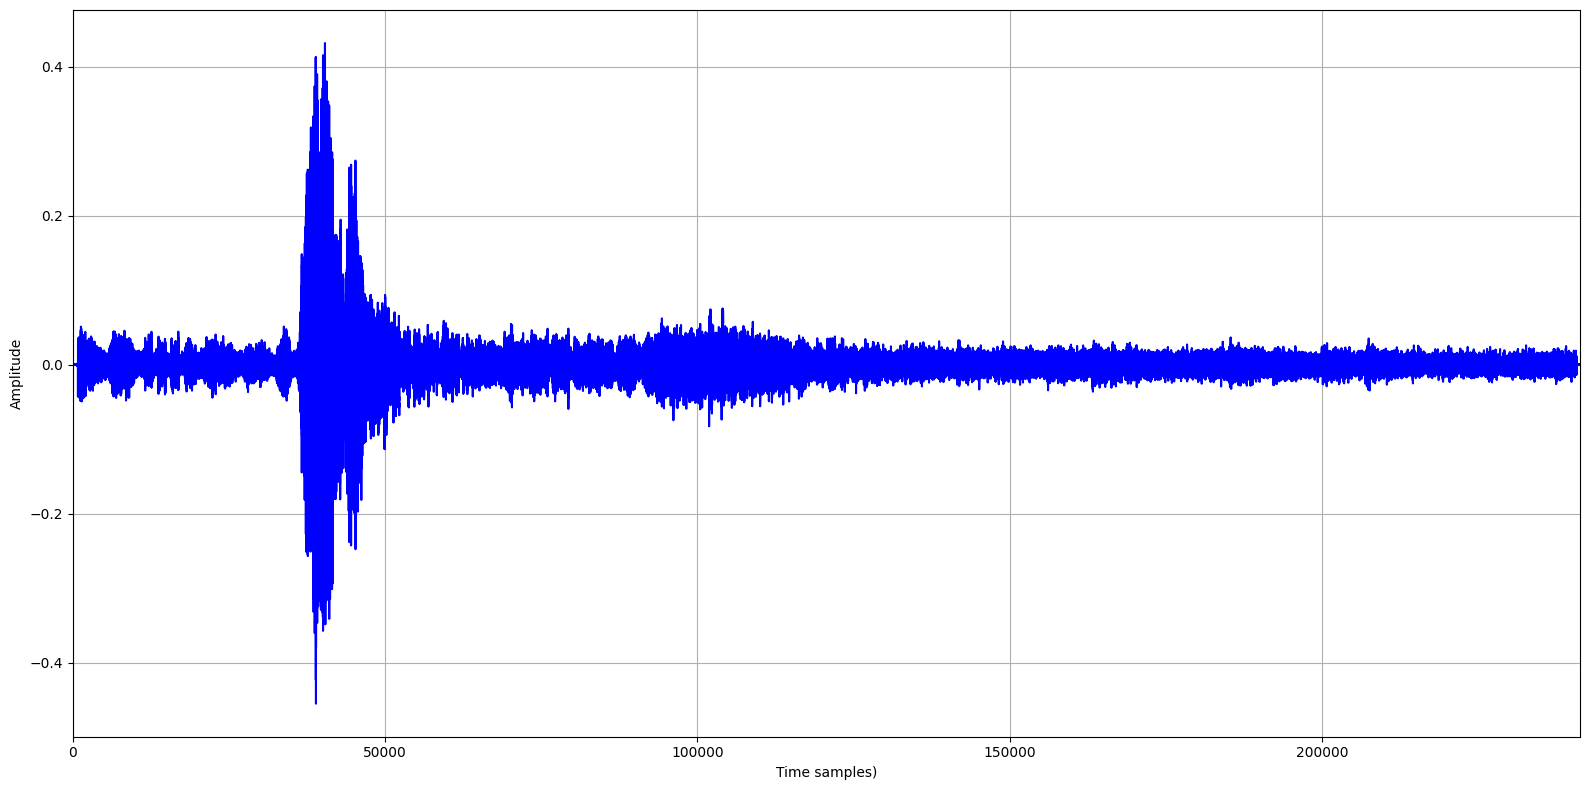

In [13]:
# Instantiate a pipeline
pipeline = MyPipeline()
# 
# # Move the computation graph to CUDA
# pipeline.to(device=torch.device("cuda"), dtype=torch.float32)
audio, label = train_ds[3]
# Perform the transform
plot_waveform(audio, 20000)

In [ ]:
features = pipeline(audio)
plot_waveform()


In [14]:
torchaudio.sox_effects.effect_names()

RuntimeError: effect_names requires sox extension which is not available. Please refer to the stacktrace above for how to resolve this.

In [ ]:
effects = [
    ['gain', '-n'],  # normalises to 0dB
    ['pitch', '5'],  # 5 cent pitch shift
    ['rate', '8000'],  # resample to 8000 Hz
]
sample_rate = 16000
waveform = 2 * torch.rand([2, sample_rate * 1]) - 1
waveform.shape
waveform

In [ ]:
waveform, sample_rate = torchaudio.sox_effects.apply_effects_tensor(waveform, sample_rate, effects, channels_first=True)